In [1]:
import pandas as pd
import numpy as np
import glob
import pickle as pkl
import os
import itertools

from sklearn.preprocessing import minmax_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import colorcet as cc

from params_opt_maps import *

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_eval=path_data+'eval/'
path_names=path_data+'names_parsed/'

In [3]:
def metrics_data_heatmap(metrics_data,res,metric='jaccard_label'):
    dat={}
    for metrics_res in metrics_data:
        dat[metrics_res['name']]=metrics_res[metric]
    dat=pd.DataFrame(dat).T
    dat=dat.loc[res.sort_values(['params_opt','param_opt_val']).index,:]
    #dat['params_opt']=dat.index.map(lambda x: res.at[x,'params_opt'])
    #dat['param_opt_val']=dat.index.map(lambda x: res.at[x,'param_opt_val'])
    #dat=dat.groupby(['params_opt','param_opt_val']).mean()
    dat.index=dat.index.map(lambda x: '-'.join(
    [str(res.at[x,'params_opt']),
     str(res.at[x,'param_opt_val'])]))
    dat=dat/np.clip(dat.max(axis=0),a_min=1e-3, a_max=None)
    sb.clustermap(dat,row_cluster=False, xticklabels=True,yticklabels=True)

In [4]:
# Map between params and model
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))# Query to remove irrelevant runs accross all models for final model selection
# Parameter values in specific models to be optimized
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))
def get_top_runs(res,param_opt_vals=param_opt_vals,params_opt_map=params_opt_map):
    """
    Find best runs for each method accross tunned params. 
    For brevity find just one saturn and scGLUE methods for orthologues and non-orthologues. 
    Compute overall score (for each method) by first minmax-normalizing scores within method 
    and then having ilisi for batch and mean of moransi and nmi_opt for bio; 
    overall score is mean of bio and batch.
    Return top runs and top setting (mean over runs) longside with median run in the setting
    """
    # Keep relevant params and name model
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    res_query=[f'model in {nonopt_models}']
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        for param,vals in params_vals:
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    #print(res_query)
    res_sub=res_sub.query(res_query).copy()
    display(res_sub.groupby(['model','params_opt'],observed=True).size())
    
    # Normalize relevant metrics per model
    metrics=['nmi_opt','moransi','ilisi_system']
    for metric in metrics:
        res_sub[metric+'_norm']=res_sub.groupby('model')[metric].transform(minmax_scale)
    # Compute batch and bio metrics
    res_sub['batch_score']=res_sub['ilisi_system_norm']
    res_sub['bio_score']=res_sub[['nmi_opt_norm','moransi_norm']].mean(axis=1)
    #res_sub['overall_score']=res_sub[['bio_score','batch_score']].mean(axis=1)
    res_sub['overall_score']=res_sub['bio_score']*0.6+res_sub['batch_score']*0.4
    
    # Top run per method
    top_runs=res_sub.groupby('model').apply(lambda x: x.index[x['overall_score'].argmax()]
                                           ).to_dict()
    # Top parameters setting per method and the middle performing run from that setting
    top_settings={}
    for model,res_model in res_sub.groupby('model'):
        setting_cols=['params_opt','param_opt_val']
        setting_means=res_model.groupby(setting_cols,observed=True)['overall_score'].mean()
        top_setting=dict(zip(setting_cols,setting_means.index[setting_means.argmax()]))
        runs_data=res_model.query(
            f'params_opt=="{top_setting["params_opt"]}" & param_opt_val== {top_setting["param_opt_val"]}')   
        mid_run=runs_data.index[runs_data.overall_score==runs_data.overall_score.median()][0]
        top_settings[model]=dict(
            params=top_setting, runs=list(runs_data.index),mid_run=mid_run)
    
    return top_runs, top_settings

In [5]:
params_opt_colors=sb.color_palette(cc.glasbey, n_colors=len(param_opt_col_map))

## Pancreas conditions MIA HPAP2

In [6]:
path_integration=path_eval+'pancreas_conditions_MIA_HPAP2/integration/'

In [7]:
# Load integration results - params and metrics
res=[]
metrics_data=[]
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl') and \
        os.path.exists(run+'scib_metrics_scaled.pkl') and\
        os.path.exists(run+'scib_metrics_data.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
        metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
        metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
        data=pd.concat([args,metrics,metrics_scl])
        name=run.split('/')[-2]
        data.name=name
        res.append(data)
        metrics_data_sub=pkl.load(open(run+'scib_metrics_data.pkl','rb'))
        metrics_data_sub['name']=name
        metrics_data.append(metrics_data_sub)
res=pd.concat(res,axis=1).T

In [8]:
#  Param that was optimised
res['params_opt']=res.params_opt.replace(params_opt_correct_map)
res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
res['param_opt_val']=res.apply(
    lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else 0,axis=1)

In [9]:
res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

In [62]:
# List all param values by param opt
#res.groupby(['param_opt_col']).apply(lambda x: sorted(x['param_opt_val'].unique())).to_dict()

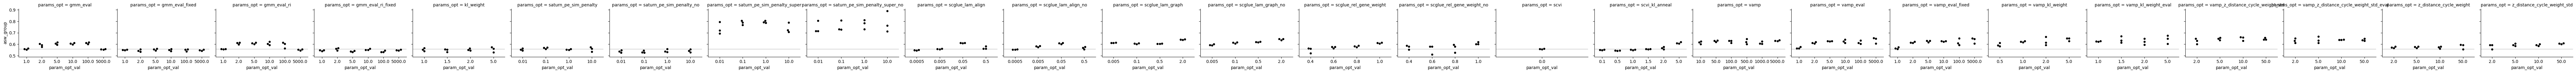

In [63]:
g=sb.catplot( x='param_opt_val', y="asw_group",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.56,lw=0.5,c='gray')

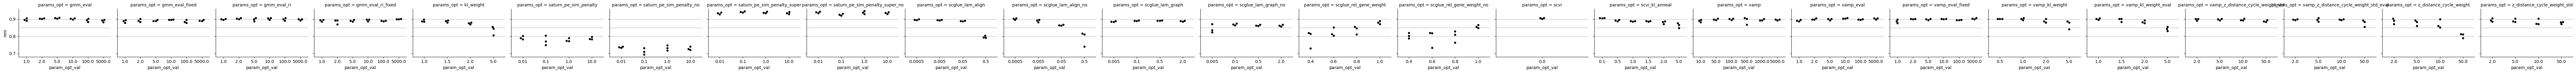

In [64]:
g=sb.catplot( x='param_opt_val', y="nmi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.85,lw=0.5,c='gray')
    ax.axhline(0.80,lw=0.5,c='gray')

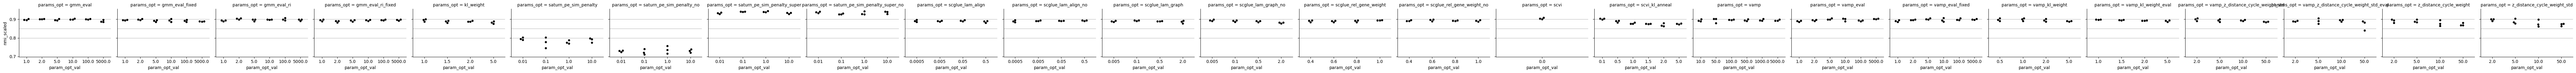

In [65]:
g=sb.catplot( x='param_opt_val', y="nmi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.85,lw=0.5,c='gray')
    ax.axhline(0.80,lw=0.5,c='gray')

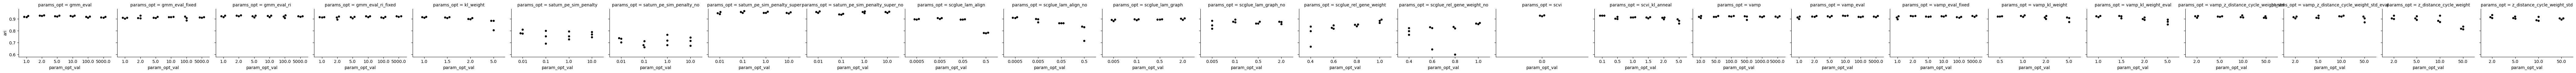

In [66]:
g=sb.catplot( x='param_opt_val', y="ari",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

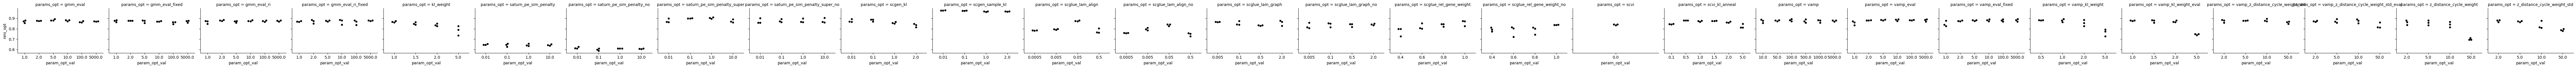

In [55]:
g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

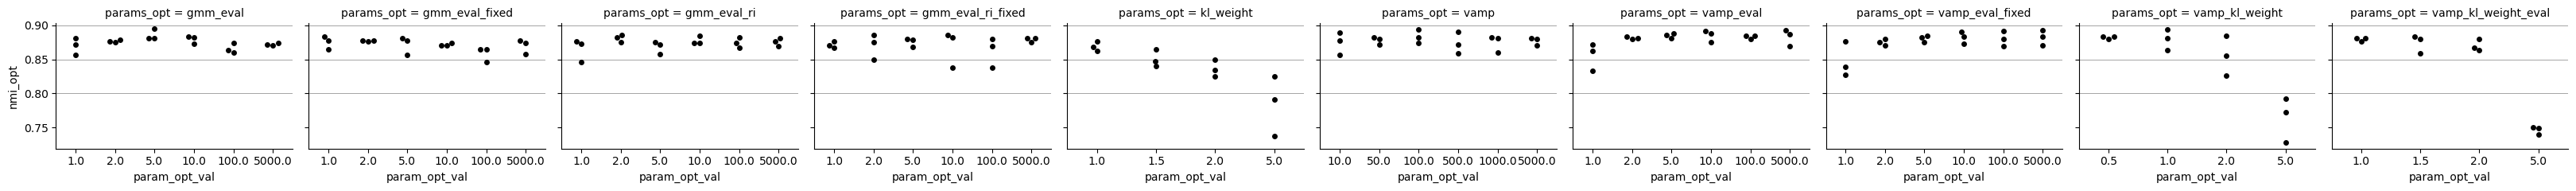

In [89]:
#Check vamp, gmm, and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.90,lw=0.5,c='gray')
#     ax.axhline(0.85,lw=0.5,c='gray')
#     ax.axhline(0.80,lw=0.5,c='gray')

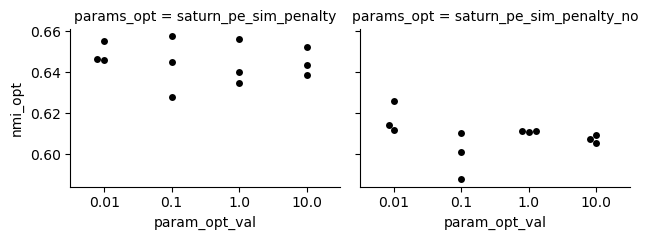

In [69]:
# Check saturn only in more detail
res_temp=res.query( 'params_opt.str.startswith("saturn") & not params_opt.str.contains("super")', 
               engine='python').copy()
res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
           kind="swarm", data=res_temp,
             sharex=False, height=2.5,aspect=1.3,color='k')

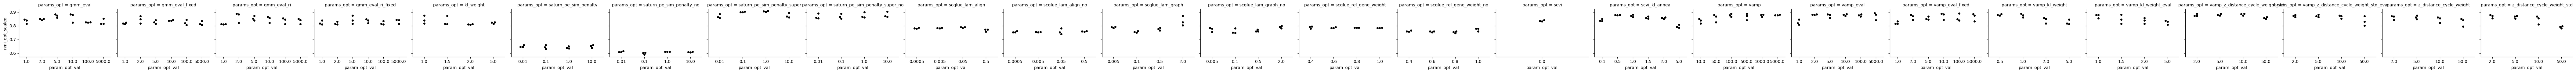

In [70]:
g=sb.catplot( x='param_opt_val', y="nmi_opt_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

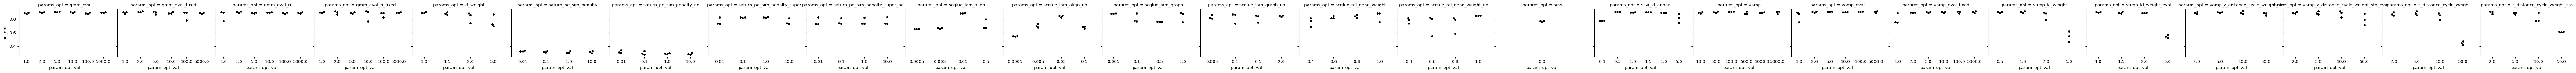

In [71]:
g=sb.catplot( x='param_opt_val', y="ari_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

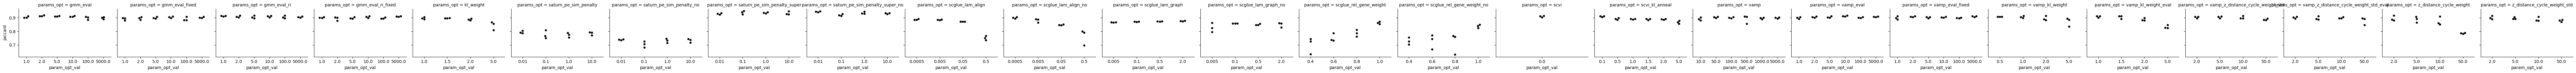

In [72]:
g=sb.catplot( x='param_opt_val', y="jaccard",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

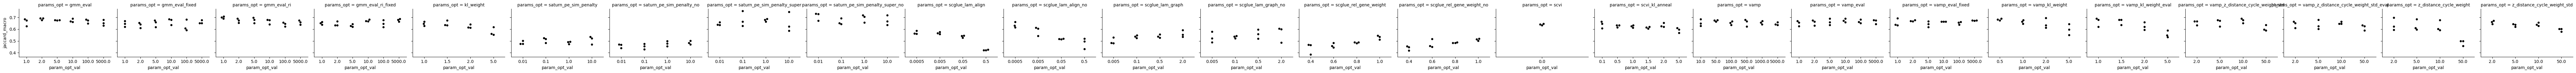

In [73]:
g=sb.catplot( x='param_opt_val', y="jaccard_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

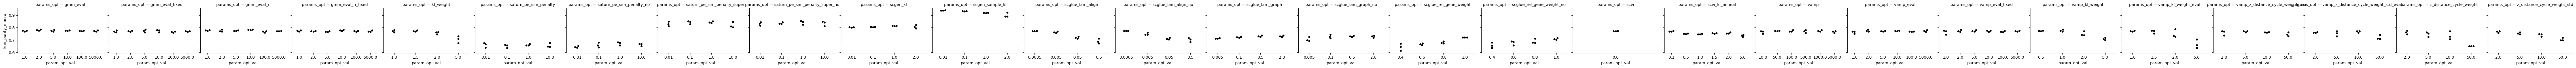

In [10]:
g=sb.catplot( x='param_opt_val', y="knn_purity_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

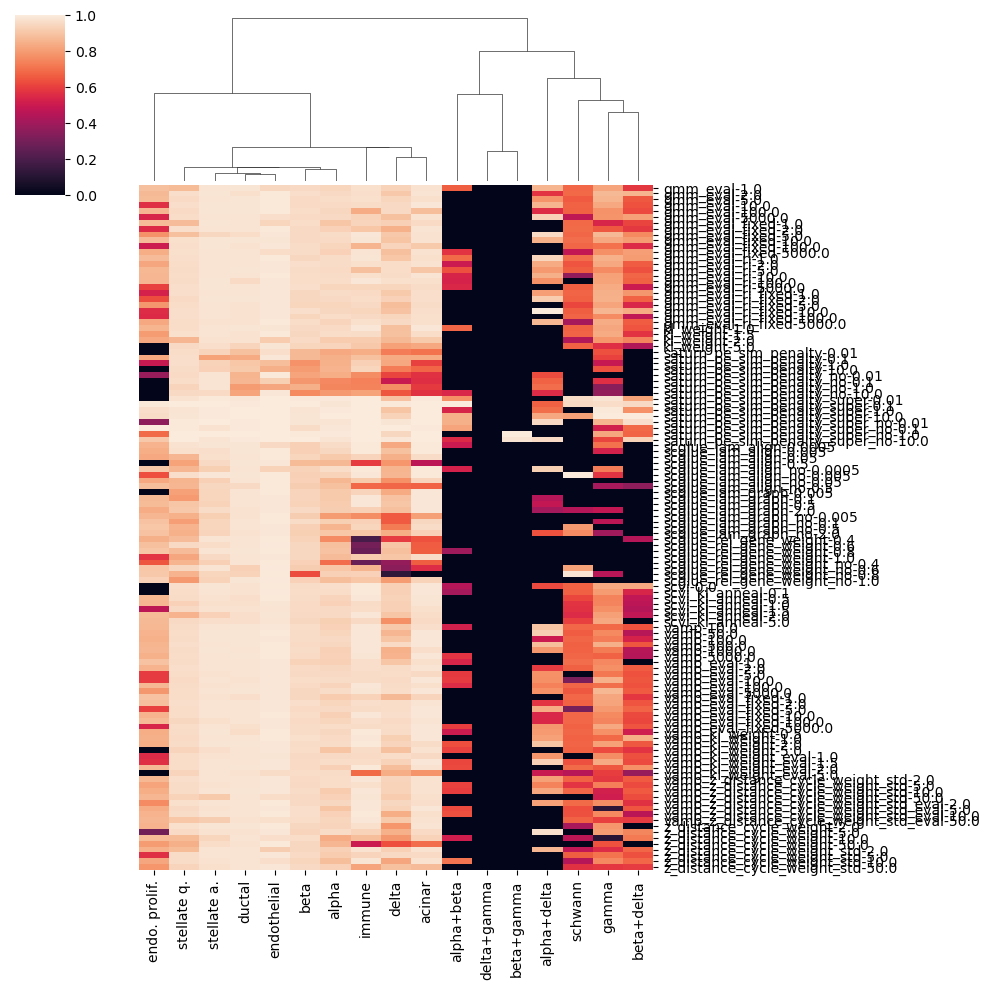

In [74]:
res_sub=res.query('seed==1')
metrics_data_heatmap(
    metrics_data=[run for run in metrics_data if run['name'] in res_sub.index],
    res=res_sub,metric='jaccard_label')

C: For example scglue_cXxtBJm8 has mixing of acinar and immune.

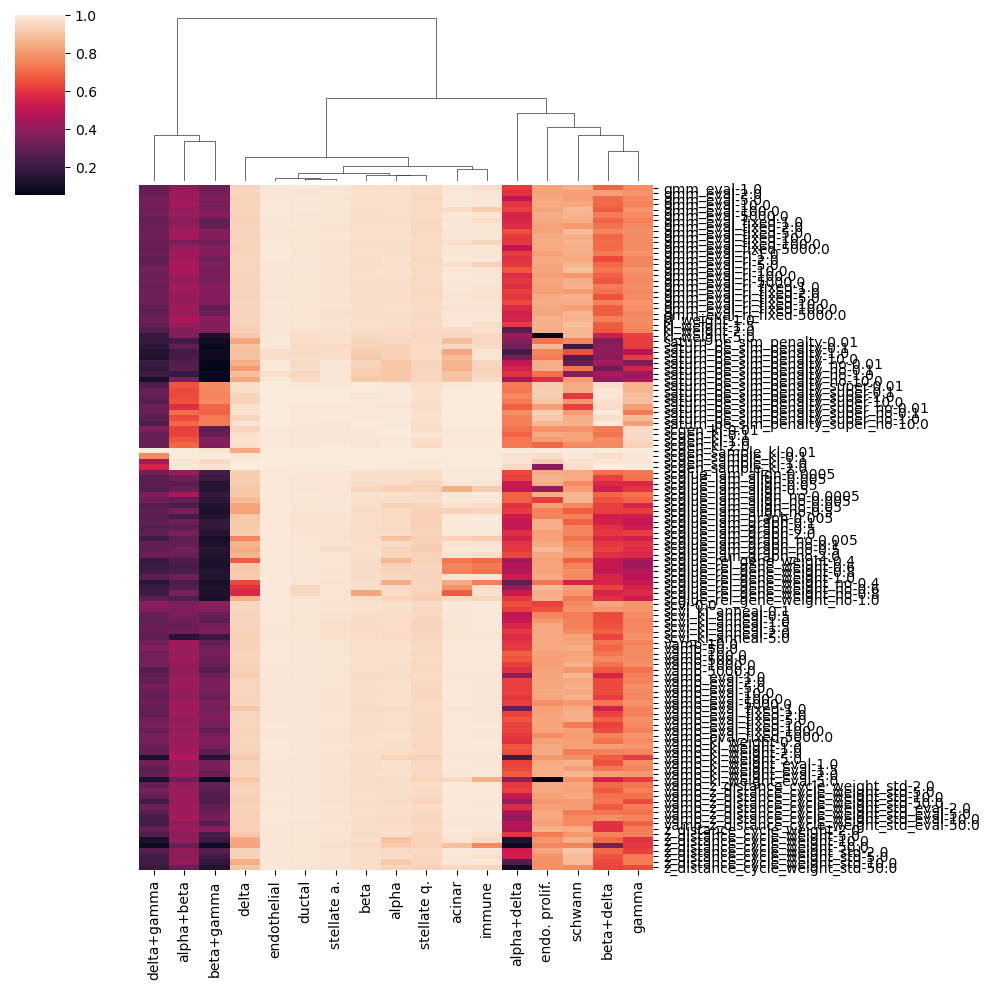

In [11]:
res_sub=res.query('seed==1')
metrics_data_heatmap(
    metrics_data=[run for run in metrics_data if run['name'] in res_sub.index],
    res=res_sub,metric='knn_purity')

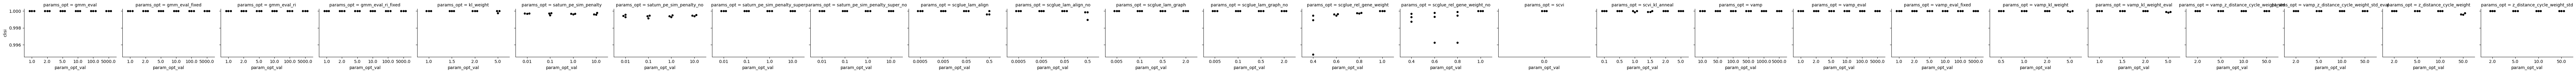

In [75]:
g=sb.catplot( x='param_opt_val', y="clisi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

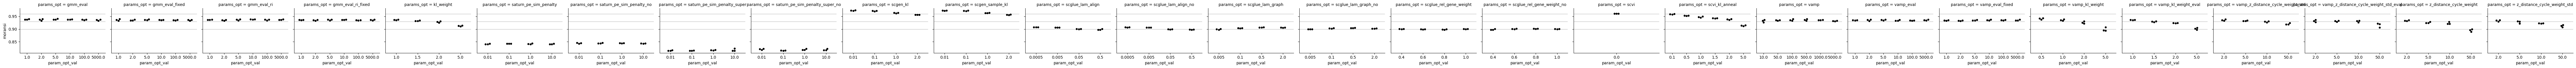

In [56]:
g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.93,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

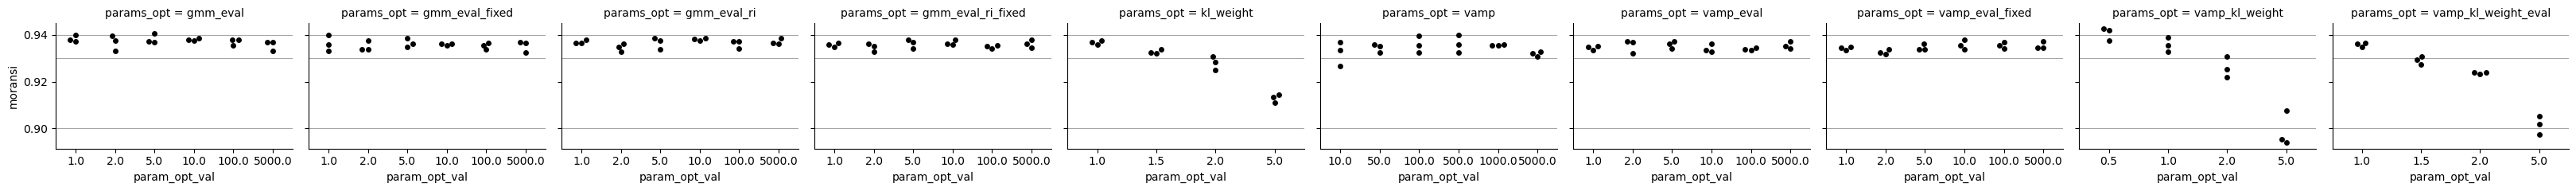

In [90]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.94,lw=0.5,c='gray')
#     ax.axhline(0.93,lw=0.5,c='gray')
#     ax.axhline(0.90,lw=0.5,c='gray')

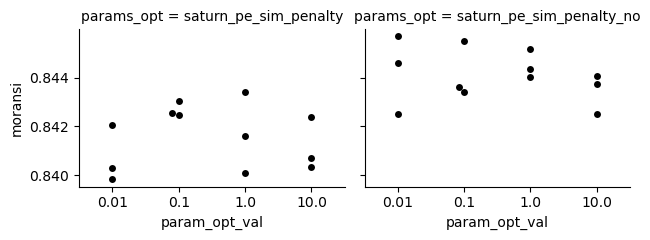

In [78]:
# Check saturn only in more detail
res_temp=res.query( 'params_opt.str.startswith("saturn") & not params_opt.str.contains("super")', 
               engine='python').copy()
res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
           kind="swarm", data=res_temp,
             sharex=False, height=2.5,aspect=1.3,color='k')

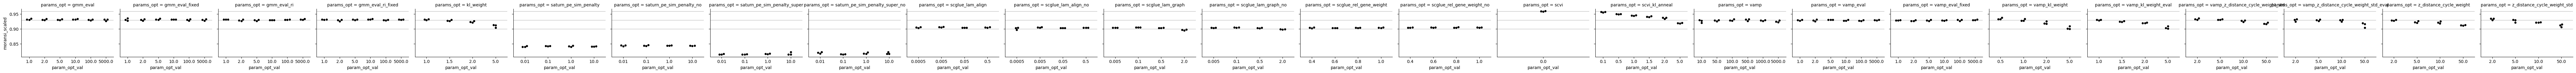

In [79]:
g=sb.catplot( x='param_opt_val', y="moransi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.93,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

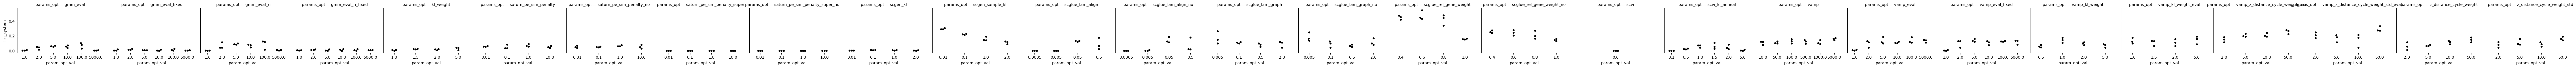

In [57]:
g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')

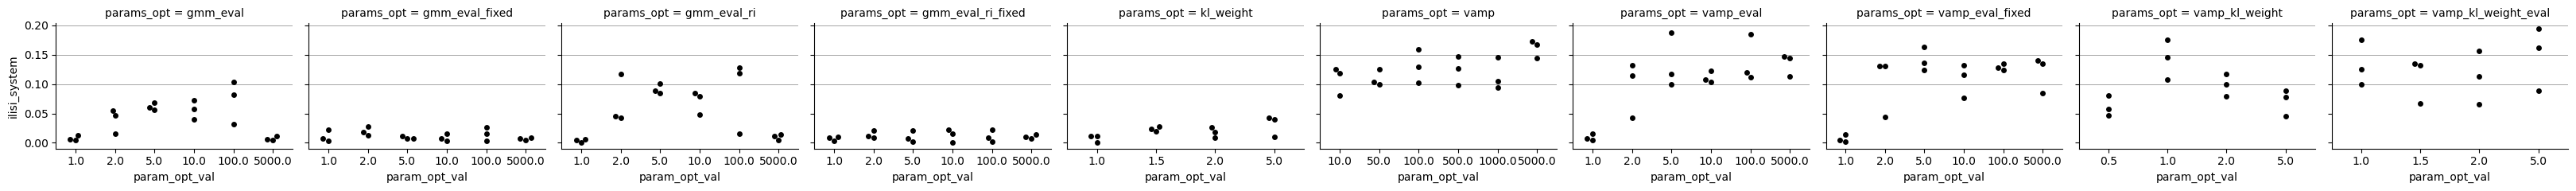

In [91]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.2,lw=0.5,c='gray')
#     ax.axhline(0.15,lw=0.5,c='gray')
#     ax.axhline(0.1,lw=0.5,c='gray')

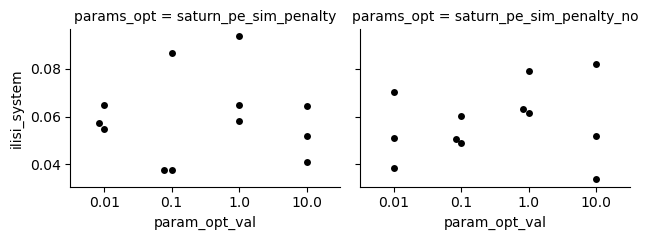

In [82]:
# Check saturn only in more detail
res_temp=res.query( 'params_opt.str.startswith("saturn") & not params_opt.str.contains("super")', 
               engine='python').copy()
res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
           kind="swarm", data=res_temp,
             sharex=False, height=2.5,aspect=1.3,color='k')

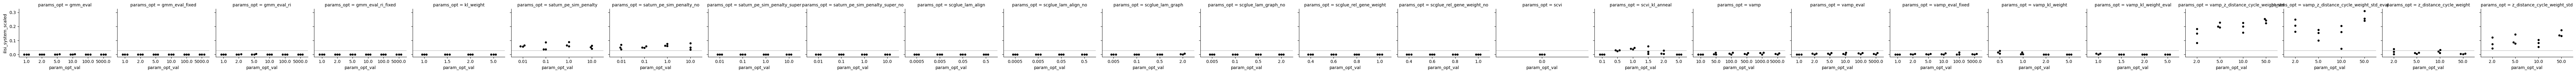

In [83]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')

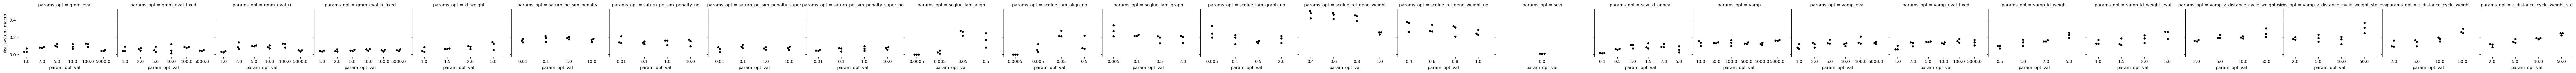

In [84]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')

C: Scalling may affect VAMP differently as the prior is not N(0,1) in the first place so maybe different features really have different importance. - Not just pushed to low values to satisfy prior.

C: z_dist_cycle_w_std combats the effect of pushing towards N(0,1) as does by scaled z_dist_cyc and not KL to N(0,1).

/tmp/ipykernel_1978033/1435659275.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_1978033/1435659275.py:2: UserWarning: 
The palette list has fewer values (21) than needed (26) and will cycle, which may produce an uninterpretable plot.
  g=sb.scatterplot(x='ilisi_system',y='nmi_opt',


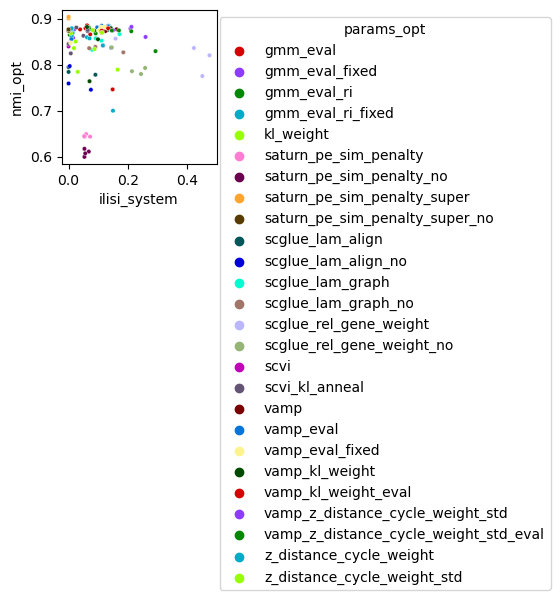

In [85]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='nmi_opt',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

/tmp/ipykernel_1978033/2110535403.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_1978033/2110535403.py:2: UserWarning: 
The palette list has fewer values (21) than needed (26) and will cycle, which may produce an uninterpretable plot.
  g=sb.scatterplot(x='ilisi_system',y='moransi',


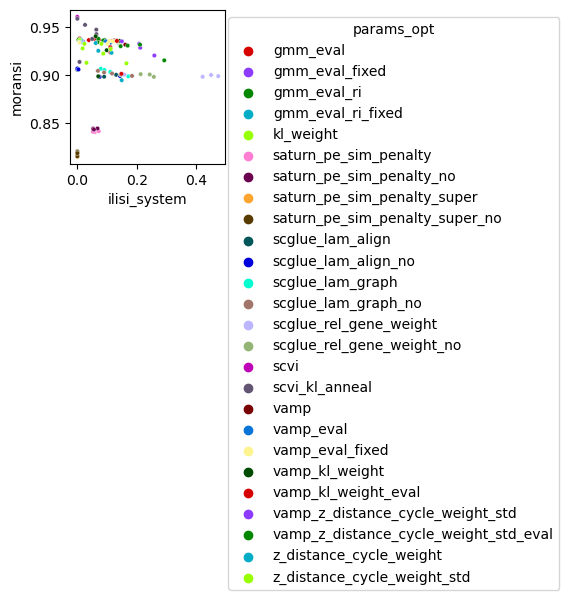

In [86]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='moransi',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='moransi',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette='tab20')
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3, 1))

### Best runs

In [60]:
top_runs,top_settings=get_top_runs(res)
print('Top runs')
display(top_runs)
print('Top settings')
for model,setting in top_settings.items():
    print(model)
    print(tuple(setting['params'].values()))
    print(setting['mid_run'])

model         params_opt                           
cVAE          kl_weight                                12
cycle         z_distance_cycle_weight_std              12
saturn        saturn_pe_sim_penalty                    12
              saturn_pe_sim_penalty_no                 12
saturn_super  saturn_pe_sim_penalty_super              12
              saturn_pe_sim_penalty_super_no           12
scglue        scglue_lam_align                         12
              scglue_lam_align_no                      12
              scglue_lam_graph                         12
              scglue_lam_graph_no                      12
              scglue_rel_gene_weight                   12
              scglue_rel_gene_weight_no                12
scvi          scvi_kl_anneal                           12
vamp          vamp_kl_weight_eval                      12
vamp_cycle    vamp_z_distance_cycle_weight_std_eval    12
dtype: int64

Top runs


{'cVAE': 'MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_9vyLTdNA',
 'cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW2.0TCW0ZCW0PsnNPC100NL2NH256_EQOgu8TK',
 'saturn': 'saturn_wxb5otVu',
 'saturn_super': 'saturn_p1zGWm08',
 'scglue': 'scglue_4G2Cx67o',
 'scvi': 'scvi_V6D1vNYW',
 'vamp': 'MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_ScGjqmvP',
 'vamp_cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW2.0TCW0ZCW0PvNPC5NL2NH256_vOMm7ryf'}

Top settings
cVAE
('kl_weight', 1.5)
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_DgrdTnwc
cycle
('z_distance_cycle_weight_std', 5.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW5.0TCW0ZCW0PsnNPC100NL2NH256_v4EYcQ5N
saturn
('saturn_pe_sim_penalty', 1.0)
saturn_BmJMp30U
saturn_super
('saturn_pe_sim_penalty_super', 1.0)
saturn_p7tIPGnm
scglue
('scglue_rel_gene_weight', 0.6)
scglue_6x3gMNmU
scvi
('scvi_kl_anneal', 0.5)
scvi_Hg2VmPJC
vamp
('vamp_kl_weight_eval', 1.0)
MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_dusAfXih
vamp_cycle
('vamp_z_distance_cycle_weight_std_eval', 2.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW2.0TCW0ZCW0PvNPC5NL2NH256_JaZpo5gj


In [61]:
res.loc[top_runs.values(),['params_opt','param_opt_val','seed']]

params_opt  \
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...                              kl_weight   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            z_distance_cycle_weight_std   
saturn_wxb5otVu                                                     saturn_pe_sim_penalty   
saturn_p1zGWm08                                            saturn_pe_sim_penalty_super_no   
scglue_4G2Cx67o                                                    scglue_rel_gene_weight   
scvi_V6D1vNYW                                                              scvi_kl_anneal   
MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZD...                    vamp_kl_weight_eval   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...  vamp_z_distance_cycle_weight_std_eval   

                                                    param_opt_val seed  
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...            1.5    1  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            2.0    2  
saturn_wxb5otVu                                               0.1    3  
saturn_p1zGWm08                                              10.0    2  
scglue_4G2Cx67o                                               0.6    1  
scvi_V6D1vNYW                                                 1.5    3  
MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZD...            1.0    2  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            2.0    1

In [62]:
pkl.dump(top_runs,open(path_integration.rstrip('/')+'_summary/top_runs.pkl','wb'))
pkl.dump(top_settings,open(path_integration.rstrip('/')+'_summary/top_settings.pkl','wb'))

## Retina adult organoid

In [6]:
path_integration=path_eval+'retina_adult_organoid/integration/'

In [7]:
# Load integration results - params and metrics
res=[]
metrics_data=[]
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl') and \
        os.path.exists(run+'scib_metrics_scaled.pkl') and\
        os.path.exists(run+'scib_metrics_data.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
        metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
        metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
        data=pd.concat([args,metrics,metrics_scl])
        name=run.split('/')[-2]
        data.name=name
        res.append(data)
        metrics_data_sub=pkl.load(open(run+'scib_metrics_data.pkl','rb'))
        metrics_data_sub['name']=name
        metrics_data.append(metrics_data_sub)
res=pd.concat(res,axis=1).T

In [8]:
#  Param that was optimised
res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
res['param_opt_val']=res.apply(
    lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else 0,axis=1)

In [9]:
res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

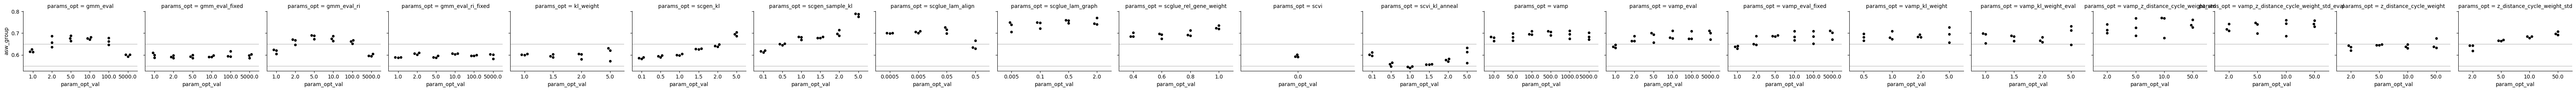

In [10]:
g=sb.catplot( x='param_opt_val', y="asw_group",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.55,lw=0.5,c='gray')
    ax.axhline(0.65,lw=0.5,c='gray')

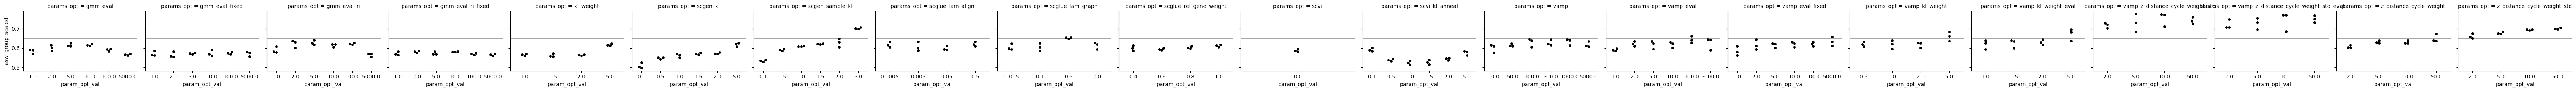

In [11]:
g=sb.catplot( x='param_opt_val', y="asw_group_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.55,lw=0.5,c='gray')
    ax.axhline(0.65,lw=0.5,c='gray')

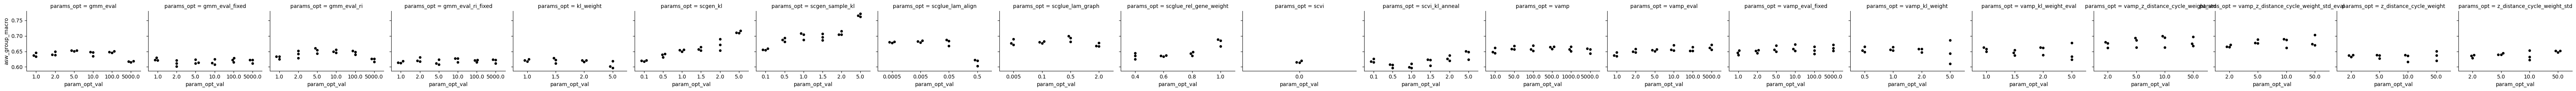

In [12]:
g=sb.catplot( x='param_opt_val', y="asw_group_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

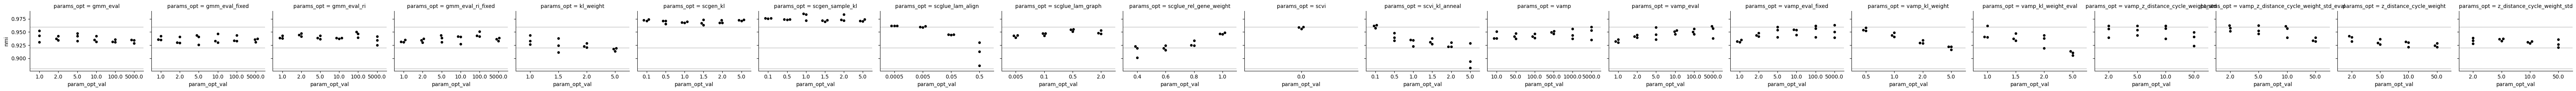

In [13]:
g=sb.catplot( x='param_opt_val', y="nmi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.88,lw=0.5,c='gray')
    ax.axhline(0.92,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

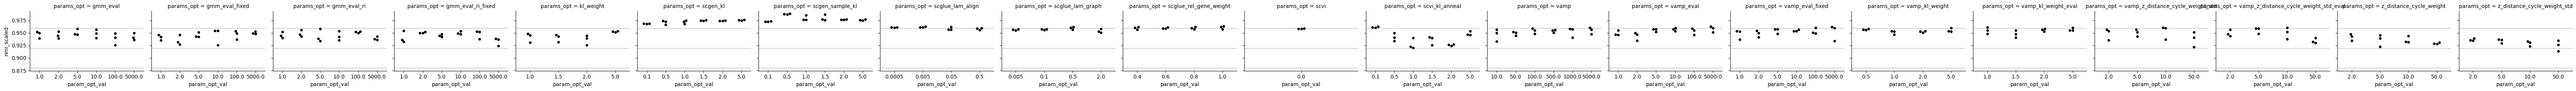

In [14]:
g=sb.catplot( x='param_opt_val', y="nmi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.88,lw=0.5,c='gray')
    ax.axhline(0.92,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

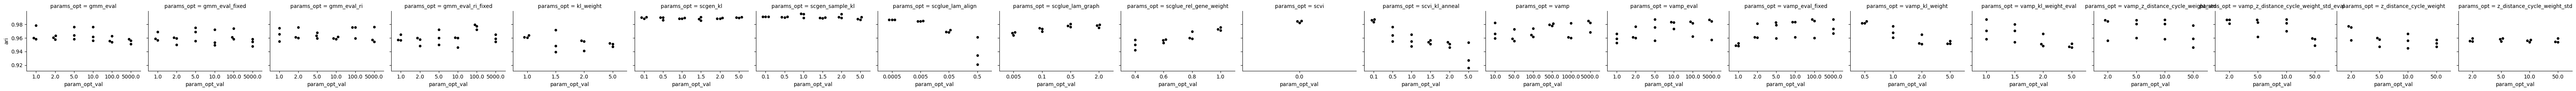

In [15]:
g=sb.catplot( x='param_opt_val', y="ari",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

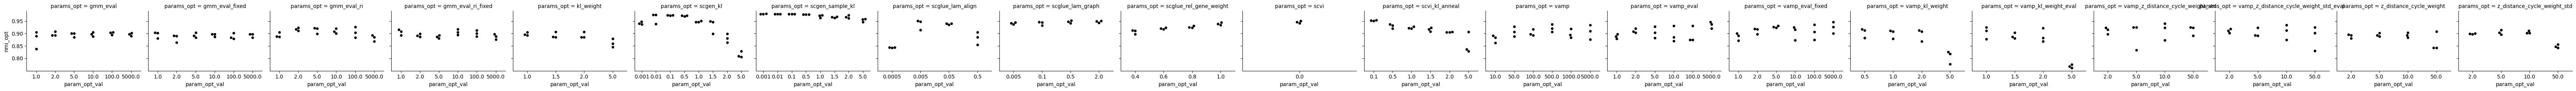

In [43]:
g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

In [17]:
# Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.95,lw=0.5,c='gray')
#     ax.axhline(0.90,lw=0.5,c='gray')
#     ax.axhline(0.85,lw=0.5,c='gray')

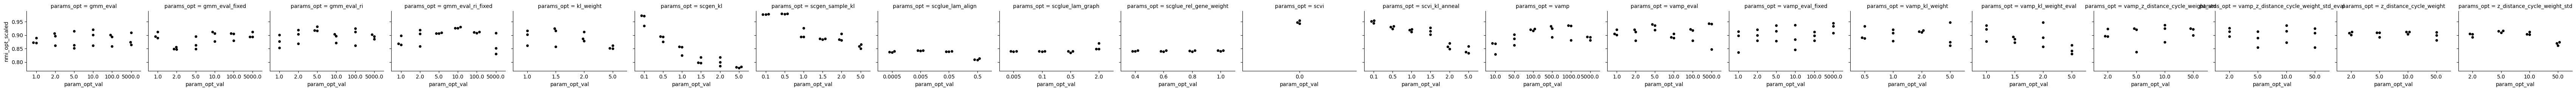

In [18]:
g=sb.catplot( x='param_opt_val', y="nmi_opt_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

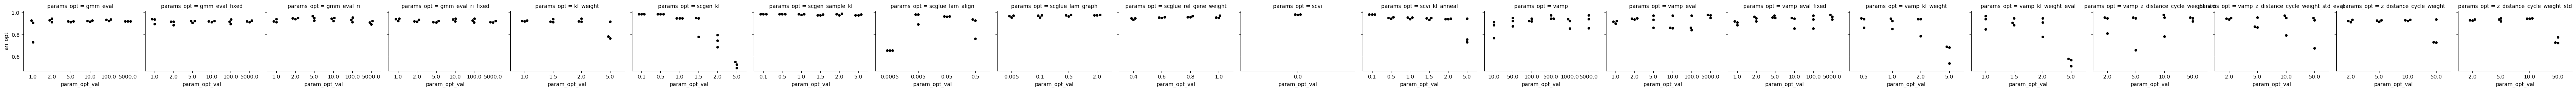

In [19]:
g=sb.catplot( x='param_opt_val', y="ari_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

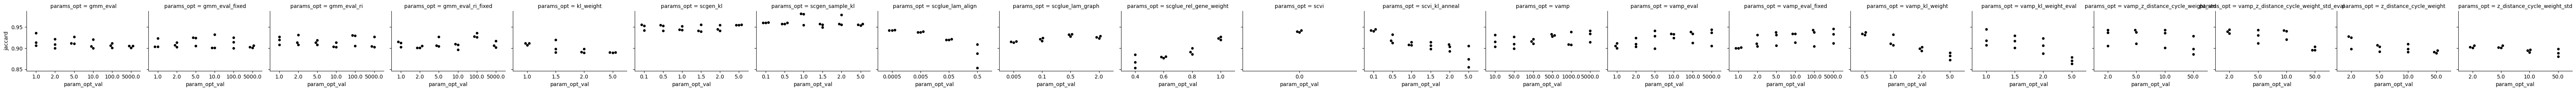

In [20]:
g=sb.catplot( x='param_opt_val', y="jaccard",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

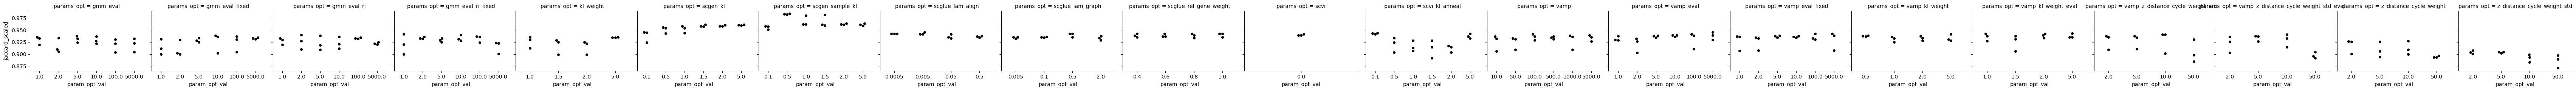

In [21]:
g=sb.catplot( x='param_opt_val', y="jaccard_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

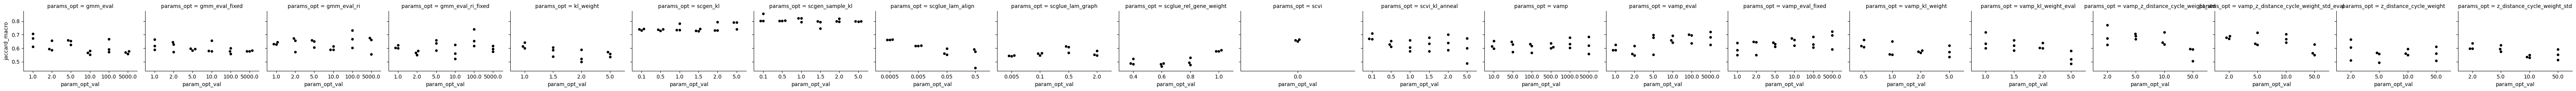

In [22]:
g=sb.catplot( x='param_opt_val', y="jaccard_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

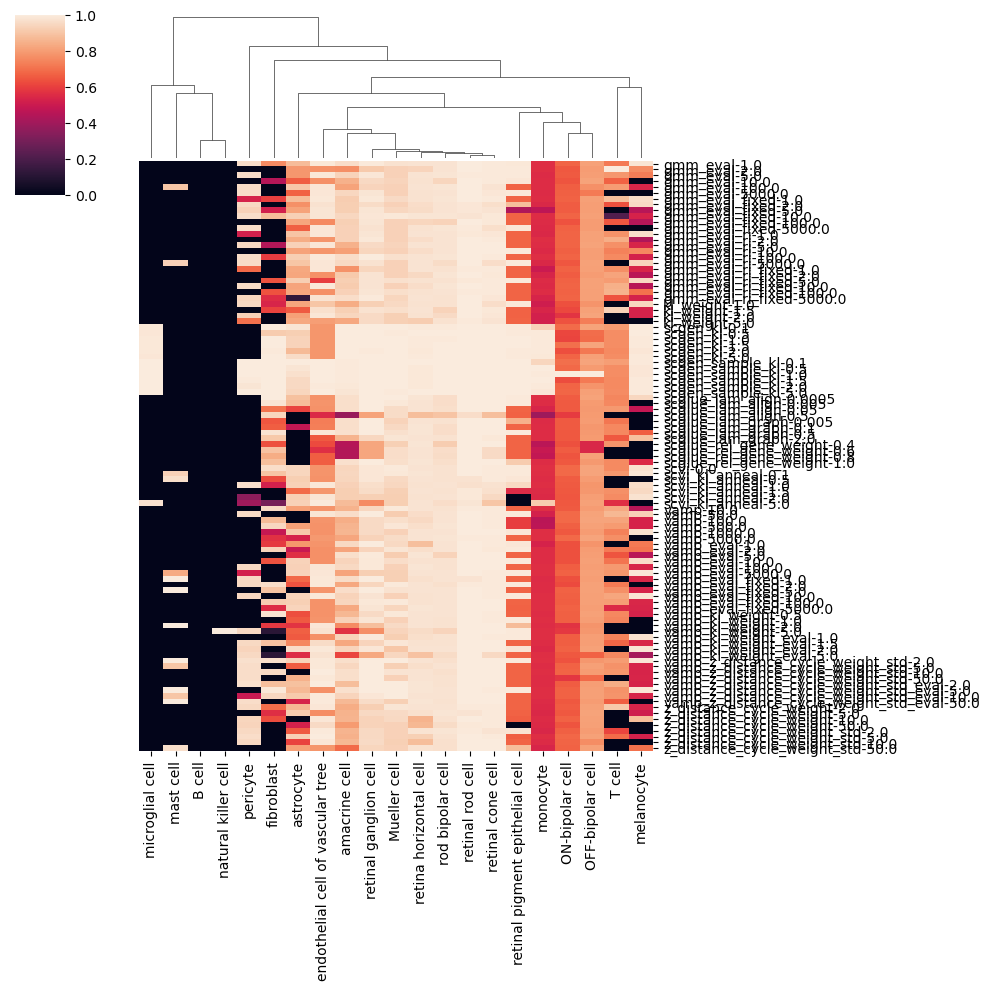

In [23]:
res_sub=res.query('seed==1')
metrics_data_heatmap(
    metrics_data=[run for run in metrics_data if run['name'] in res_sub.index],
    res=res_sub,metric='jaccard_label')

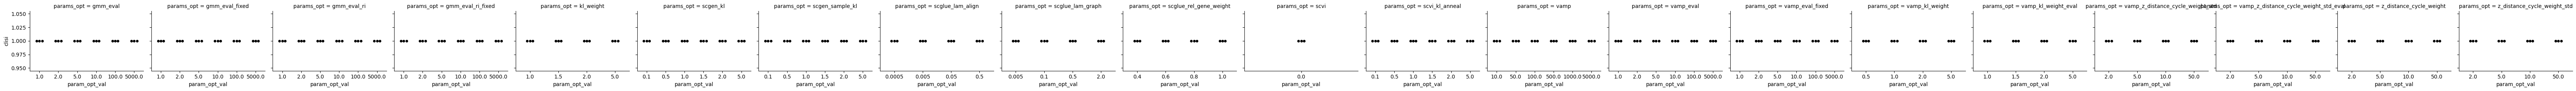

In [24]:
g=sb.catplot( x='param_opt_val', y="clisi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

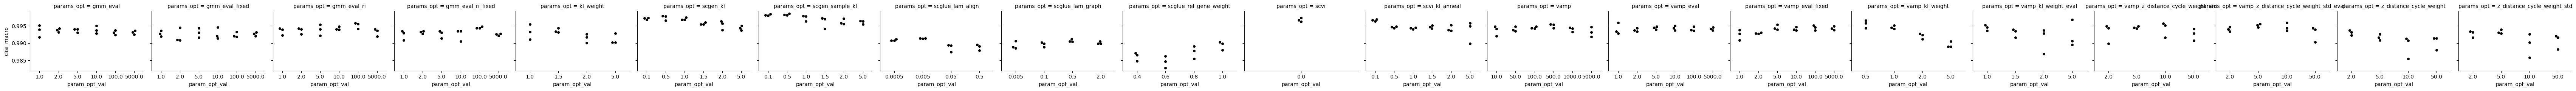

In [25]:
g=sb.catplot( x='param_opt_val', y="clisi_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

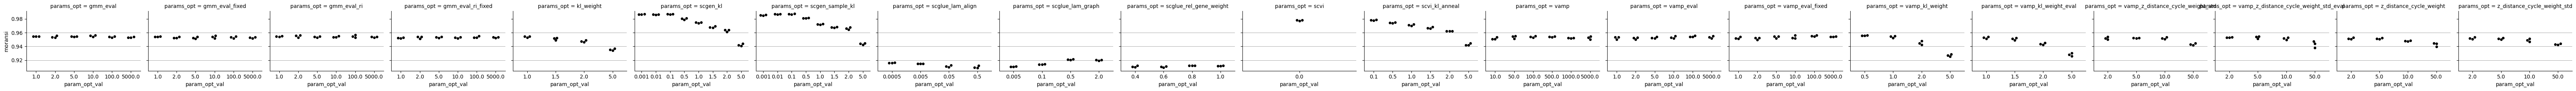

In [44]:
g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.92,lw=0.5,c='gray')
    ax.axhline(0.94,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

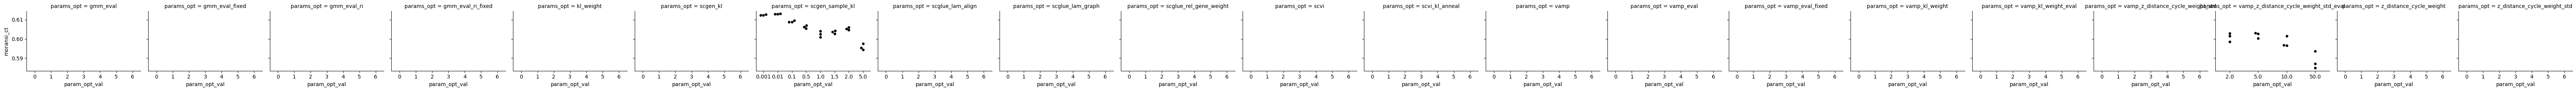

In [11]:
g=sb.catplot( x='param_opt_val', y="moransi_ct",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

In [27]:
# Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.96,lw=0.5,c='gray')
#     ax.axhline(0.95,lw=0.5,c='gray')
#     ax.axhline(0.94,lw=0.5,c='gray')

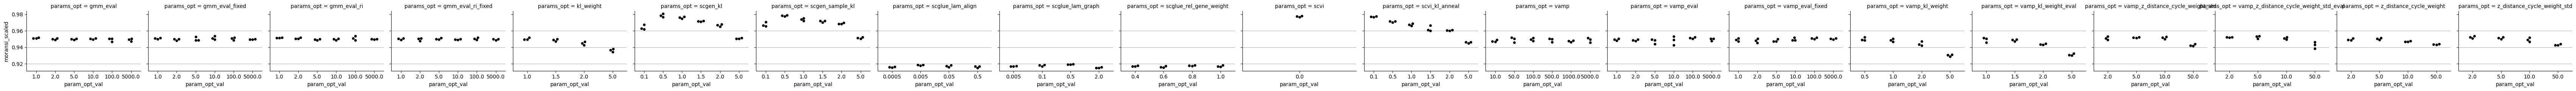

In [28]:
g=sb.catplot( x='param_opt_val', y="moransi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.92,lw=0.5,c='gray')
    ax.axhline(0.94,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

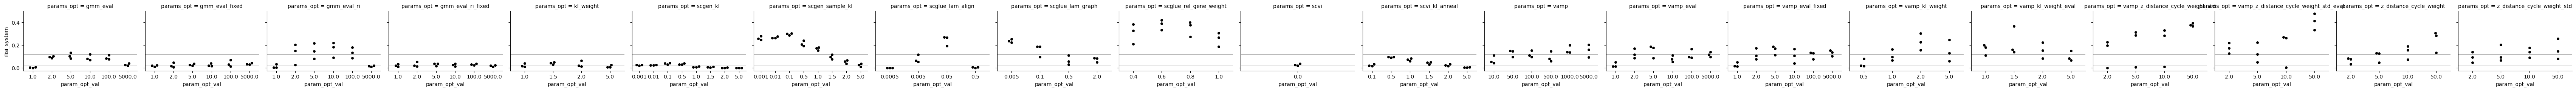

In [45]:
g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.02,lw=0.5,c='gray')
    ax.axhline(0.12,lw=0.5,c='gray')
    ax.axhline(0.22,lw=0.5,c='gray')

In [30]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.2,lw=0.5,c='gray')
#     ax.axhline(0.15,lw=0.5,c='gray')
#     ax.axhline(0.1,lw=0.5,c='gray')

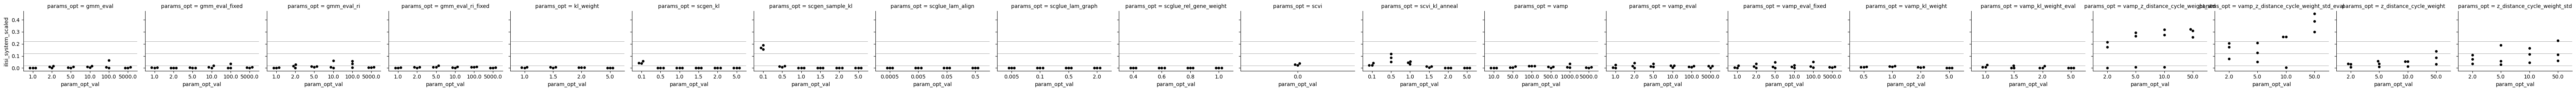

In [31]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.02,lw=0.5,c='gray')
    ax.axhline(0.12,lw=0.5,c='gray')
    ax.axhline(0.22,lw=0.5,c='gray')

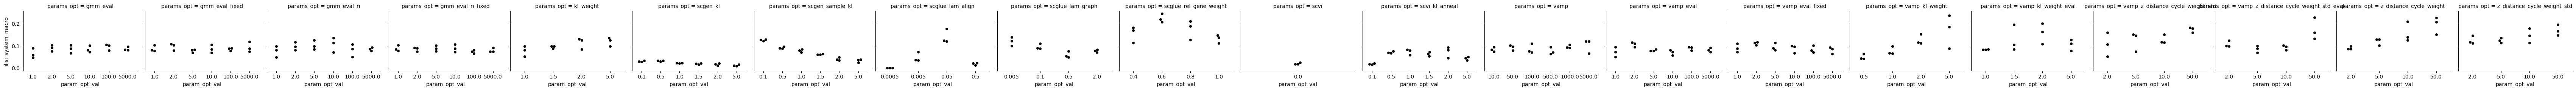

In [32]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

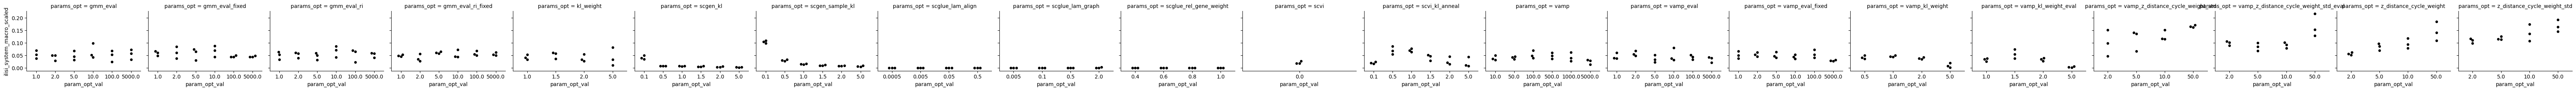

In [33]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_macro_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

/tmp/ipykernel_43781/1435659275.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_43781/1435659275.py:2: UserWarning: The palette list has more values (31) than needed (21), which may not be intended.
  g=sb.scatterplot(x='ilisi_system',y='nmi_opt',


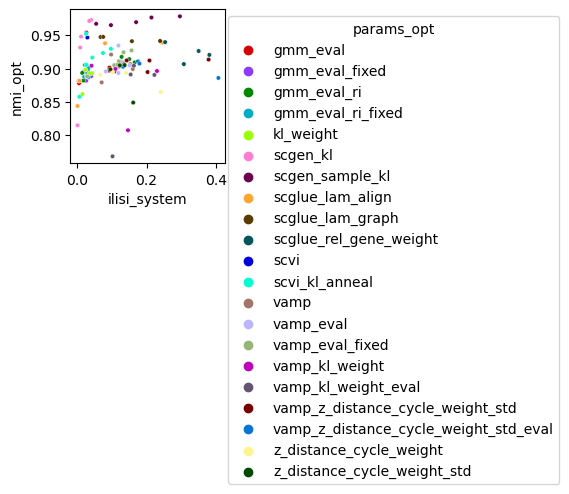

In [34]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='nmi_opt',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

/tmp/ipykernel_43781/2110535403.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_43781/2110535403.py:2: UserWarning: The palette list has more values (31) than needed (21), which may not be intended.
  g=sb.scatterplot(x='ilisi_system',y='moransi',


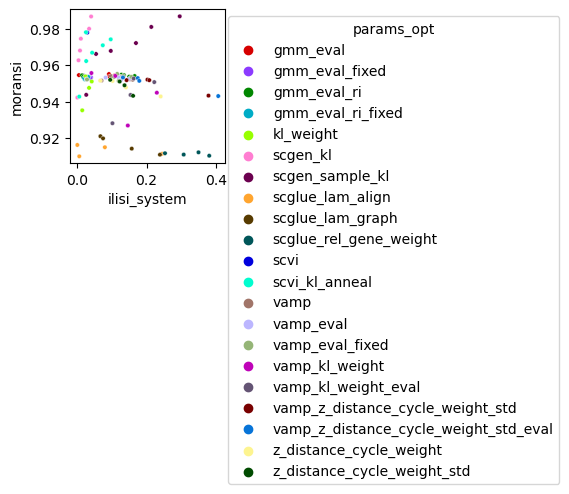

In [35]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='moransi',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

In [75]:
# Examples
# for params,run_dir in res.groupby(['params_opt','param_opt_val']).apply(
#     lambda x: x.sort_values('ilisi_system',ascending=True).index[0]).iteritems():
    
#     print(params,run_dir)
#     display(res.loc[run_dir,['ilisi_system','asw_group']])
#     with plt.rc_context({'figure.figsize':(40,10)}):
#         path_run=path_integration+run_dir+'/'
#         for img_fn in ['umap.png','losses.png']:
#             img = mpimg.imread(path_run+img_fn)
#             imgplot = plt.imshow(img)
#             plt.show()

### Best runs

In [67]:
top_runs,top_settings=get_top_runs(res)
print('Top runs')
display(top_runs)
print('Top settings')
for model,setting in top_settings.items():
    print(model)
    print(tuple(setting['params'].values()))
    print(setting['mid_run'])

model       params_opt                           
cVAE        kl_weight                                12
cycle       z_distance_cycle_weight_std              12
scglue      scglue_lam_align                         12
            scglue_lam_graph                         12
            scglue_rel_gene_weight                   12
scvi        scvi_kl_anneal                           12
vamp        vamp_kl_weight_eval                      12
vamp_cycle  vamp_z_distance_cycle_weight_std_eval    12
dtype: int64

Top runs


{'cVAE': 'MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_v30NkI8y',
 'cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW5.0TCW0ZCW0PsnNPC100NL2NH256_2WZ7tlIY',
 'scglue': 'scglue_Kioguhtp',
 'scvi': 'scvi_t4Cns0No',
 'vamp': 'MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_NdAaXz3S',
 'vamp_cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW10.0TCW0ZCW0PvNPC5NL2NH256_or4EBiDg'}

Top settings
cVAE
('kl_weight', 1.5)
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_cfio9skI
cycle
('z_distance_cycle_weight_std', 5.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW5.0TCW0ZCW0PsnNPC100NL2NH256_ly8OzI7n
scglue
('scglue_rel_gene_weight', 0.8)
scglue_qtKBHs2V
scvi
('scvi_kl_anneal', 0.5)
scvi_I07wyTsp
vamp
('vamp_kl_weight_eval', 1.5)
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_RsYjxK0D
vamp_cycle
('vamp_z_distance_cycle_weight_std_eval', 2.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW2.0TCW0ZCW0PvNPC5NL2NH256_RLhoBHIl


In [68]:
res.loc[top_runs.values(),['params_opt','param_opt_val','seed']]

params_opt  \
MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZD...                              kl_weight   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            z_distance_cycle_weight_std   
scglue_Kioguhtp                                                    scglue_rel_gene_weight   
scvi_t4Cns0No                                                              scvi_kl_anneal   
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...                    vamp_kl_weight_eval   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...  vamp_z_distance_cycle_weight_std_eval   

                                                    param_opt_val seed  
MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZD...            2.0    1  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            5.0    2  
scglue_Kioguhtp                                               0.8    3  
scvi_t4Cns0No                                                 0.5    2  
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...            1.5    3  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...           10.0    1

In [69]:
pkl.dump(top_runs,open(path_integration.rstrip('/')+'_summary/top_runs.pkl','wb'))
pkl.dump(top_settings,open(path_integration.rstrip('/')+'_summary/top_settings.pkl','wb'))

### Example runs - nonbenchmarked

In [17]:
example_runs={
    'scgen_sample':res.query('params_opt=="scgen_sample_kl" & seed==1 & kl_weight==0.1').index[0],
    'scgen_system':res.query('params_opt=="scgen_kl" & seed==1 & kl_weight==0.1').index[0],
}
pkl.dump(example_runs,open(path_integration.rstrip('/')+'_summary/example_runs.pkl','wb'))

## Adipose sc sn updated

In [58]:
path_integration=path_eval+'adipose_sc_sn_updated/integration/'

In [59]:
# Load integration results - params and metrics
res=[]
metrics_data=[]
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl') and \
        os.path.exists(run+'scib_metrics_scaled.pkl') and\
        os.path.exists(run+'scib_metrics_data.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
        metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
        metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
        data=pd.concat([args,metrics,metrics_scl])
        name=run.split('/')[-2]
        data.name=name
        res.append(data)
        metrics_data_sub=pkl.load(open(run+'scib_metrics_data.pkl','rb'))
        metrics_data_sub['name']=name
        metrics_data.append(metrics_data_sub)
res=pd.concat(res,axis=1).T

In [60]:
#  Param that was optimised
res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
res['param_opt_val']=res.apply(
    lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
              else x[x['param_opt_col']]['weight_end']) 
    if x['param_opt_col'] is not None else 0,axis=1)

In [61]:
res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

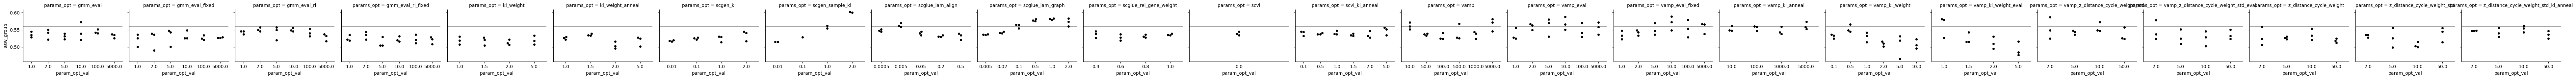

In [62]:
g=sb.catplot( x='param_opt_val', y="asw_group",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.56,lw=0.5,c='gray')

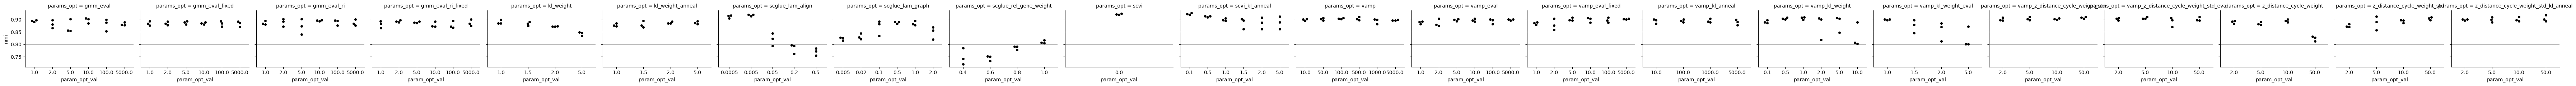

In [136]:
g=sb.catplot( x='param_opt_val', y="nmi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.85,lw=0.5,c='gray')
    ax.axhline(0.80,lw=0.5,c='gray')

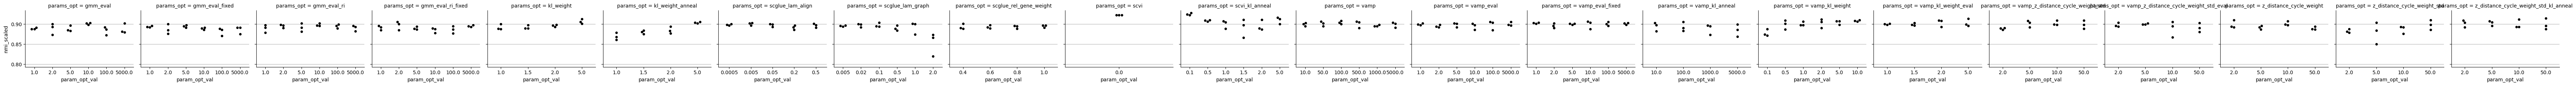

In [137]:
g=sb.catplot( x='param_opt_val', y="nmi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.85,lw=0.5,c='gray')
    ax.axhline(0.80,lw=0.5,c='gray')

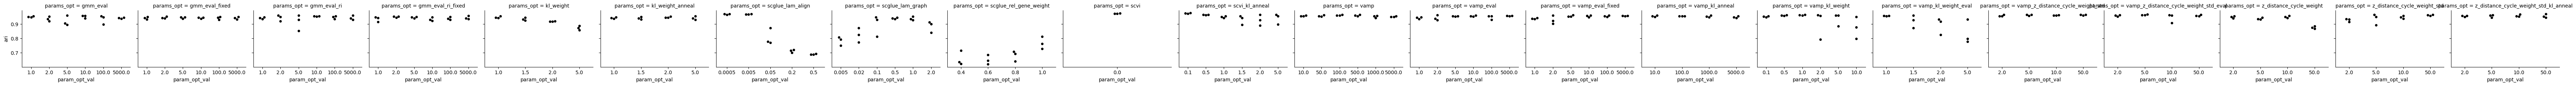

In [138]:
g=sb.catplot( x='param_opt_val', y="ari",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

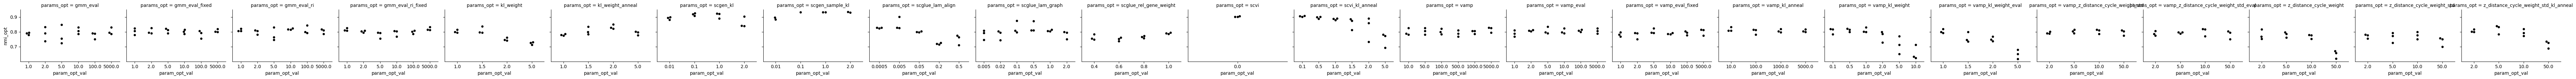

In [63]:
g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

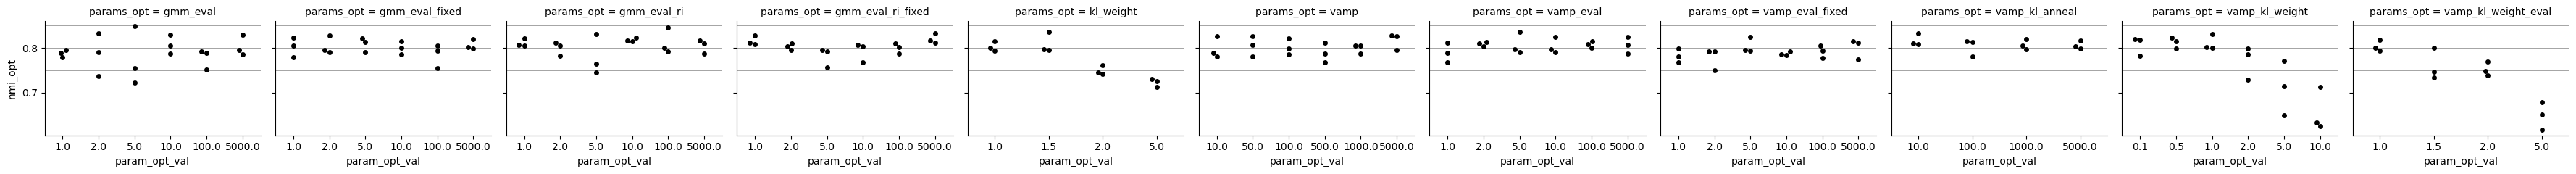

In [140]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.85,lw=0.5,c='gray')
#     ax.axhline(0.80,lw=0.5,c='gray')
#     ax.axhline(0.75,lw=0.5,c='gray')

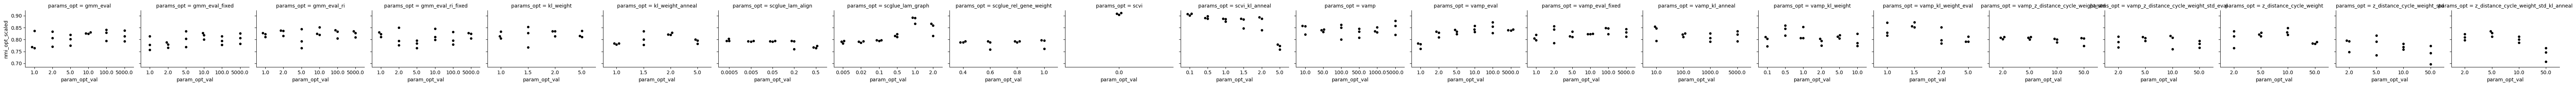

In [141]:
g=sb.catplot( x='param_opt_val', y="nmi_opt_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

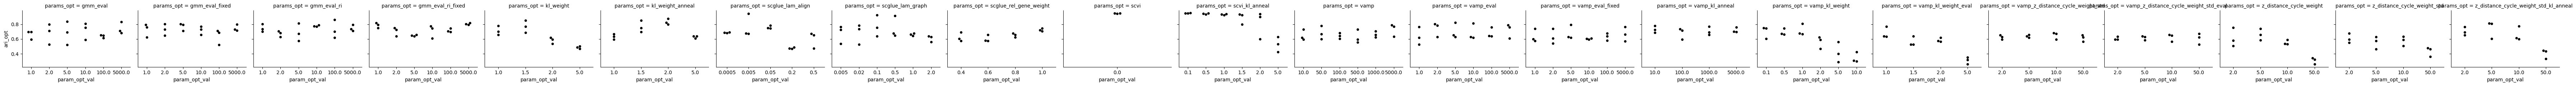

In [142]:
g=sb.catplot( x='param_opt_val', y="ari_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

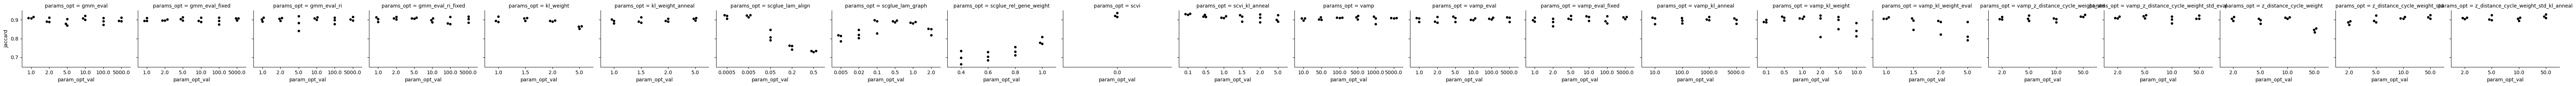

In [143]:
g=sb.catplot( x='param_opt_val', y="jaccard",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

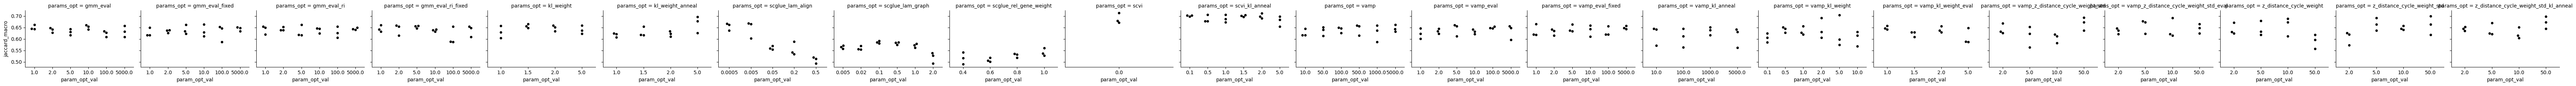

In [144]:
g=sb.catplot( x='param_opt_val', y="jaccard_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

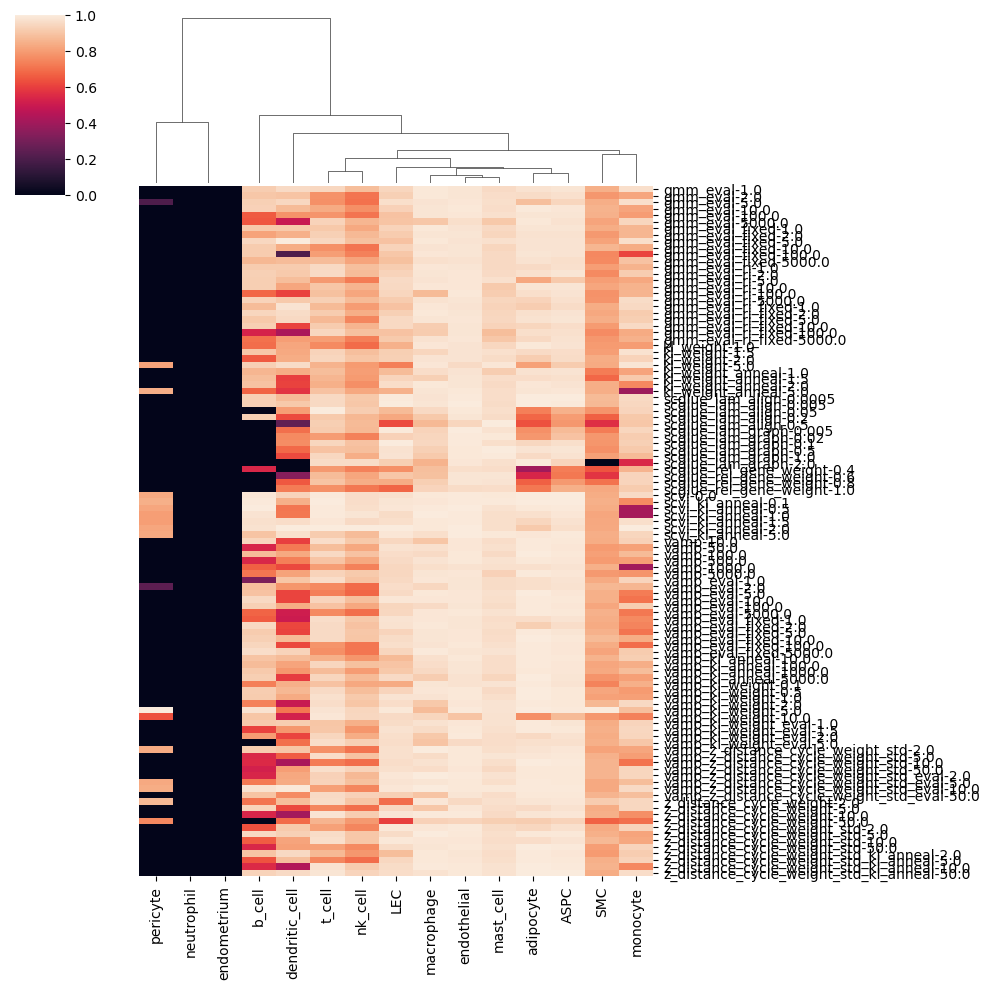

In [145]:
res_sub=res.query('seed==1')
metrics_data_heatmap(
    metrics_data=[run for run in metrics_data if run['name'] in res_sub.index],
    res=res_sub,metric='jaccard_label')

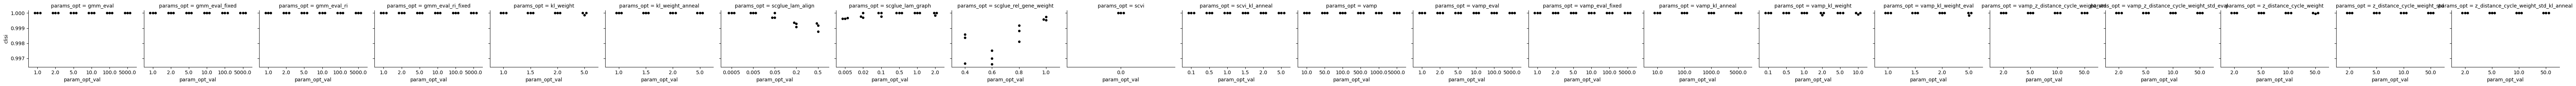

In [146]:
g=sb.catplot( x='param_opt_val', y="clisi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

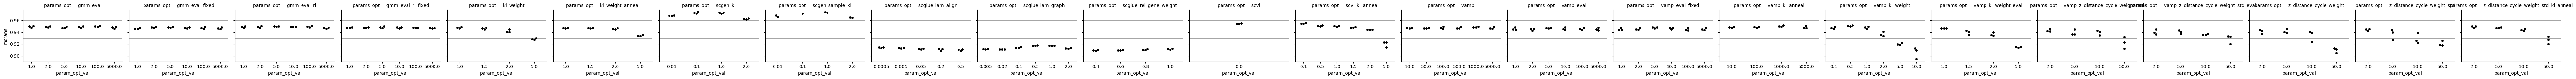

In [64]:
g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.93,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

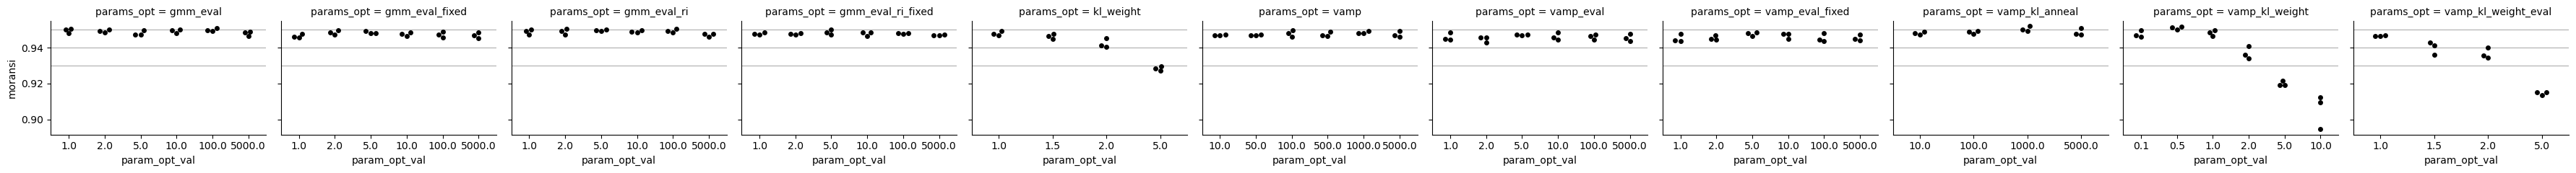

In [148]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.95,lw=0.5,c='gray')
#     ax.axhline(0.94,lw=0.5,c='gray')
#     ax.axhline(0.93,lw=0.5,c='gray')

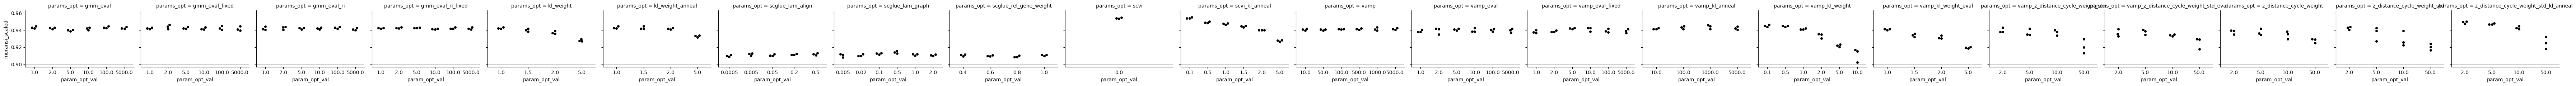

In [149]:
g=sb.catplot( x='param_opt_val', y="moransi_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.90,lw=0.5,c='gray')
    ax.axhline(0.93,lw=0.5,c='gray')
    ax.axhline(0.96,lw=0.5,c='gray')

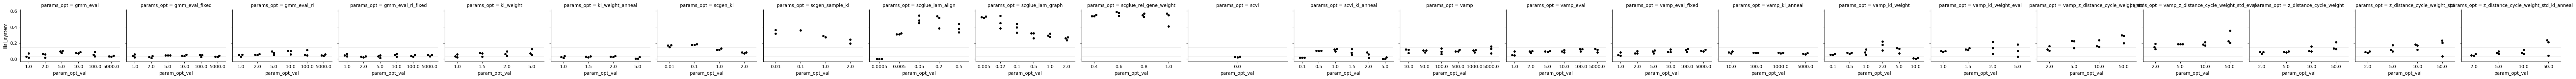

In [65]:
g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')
    ax.axhline(0.15,lw=0.5,c='gray')

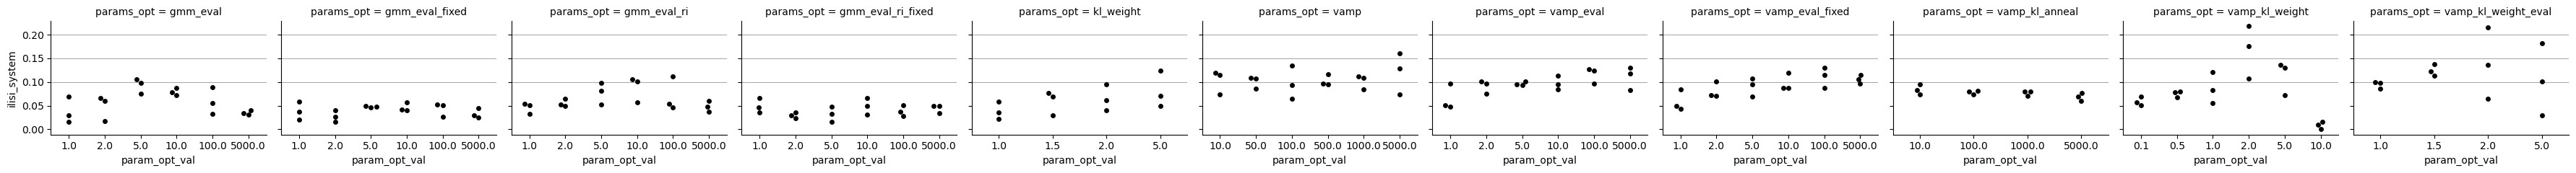

In [151]:
# # Check vamp and cVAE in more detail only
# res_temp=res.query( '(params_opt.str.startswith("vamp") & not params_opt.str.contains("cycle")) | params_opt.str.startswith("gmm") | params_opt=="kl_weight"', 
#                engine='python').copy()
# res_temp['params_opt']=res_temp['params_opt'].cat.remove_unused_categories()
# g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
#            kind="swarm", data=res_temp,
#              sharex=False, height=2.5,aspect=1.3,color='k')
# for ax in g.axes.ravel():
#     ax.axhline(0.2,lw=0.5,c='gray')
#     ax.axhline(0.15,lw=0.5,c='gray')
#     ax.axhline(0.1,lw=0.5,c='gray')

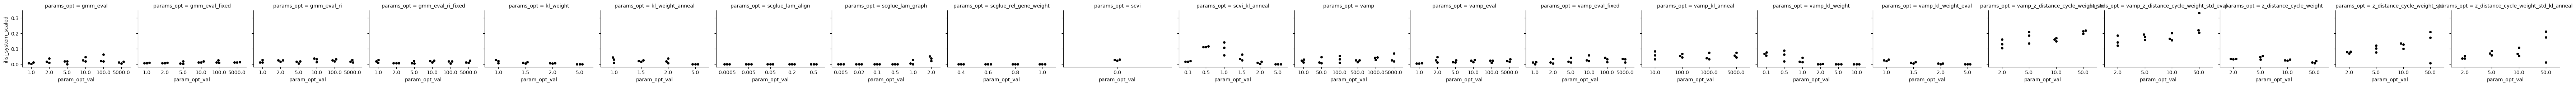

In [152]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_scaled",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')

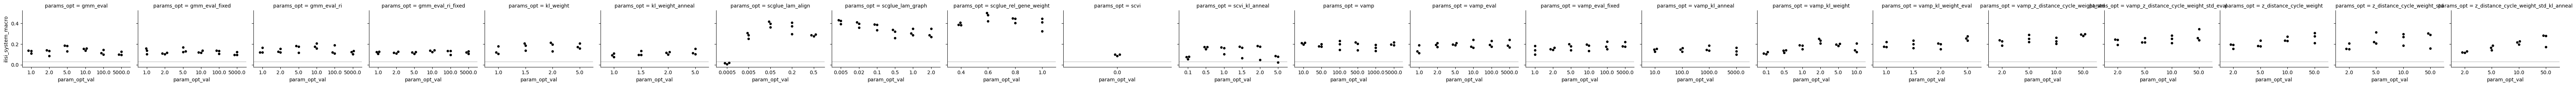

In [153]:
g=sb.catplot( x='param_opt_val', y="ilisi_system_macro",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')

/tmp/ipykernel_1978033/1435659275.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_1978033/1435659275.py:2: UserWarning: 
The palette list has fewer values (21) than needed (22) and will cycle, which may produce an uninterpretable plot.
  g=sb.scatterplot(x='ilisi_system',y='nmi_opt',


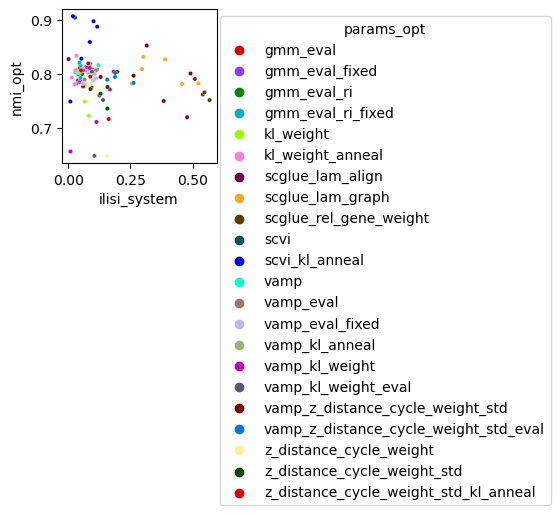

In [154]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='nmi_opt',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

/tmp/ipykernel_1978033/2110535403.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=res.groupby(['params_opt','param_opt_val'],observed=True
/tmp/ipykernel_1978033/2110535403.py:2: UserWarning: 
The palette list has fewer values (21) than needed (22) and will cycle, which may produce an uninterpretable plot.
  g=sb.scatterplot(x='ilisi_system',y='moransi',


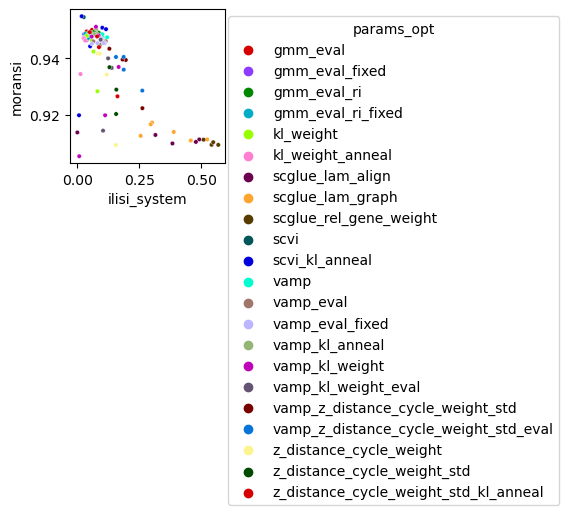

In [155]:
rcParams['figure.figsize']=(2,2)
g=sb.scatterplot(x='ilisi_system',y='moransi',
               hue='params_opt',
               data=res.groupby(['params_opt','param_opt_val'],observed=True
                               ).mean().reset_index(),
                palette=params_opt_colors,s=10)
sb.move_legend(g, loc='upper right',bbox_to_anchor=(3.2, 1))

### Best runs

In [75]:
top_runs,top_settings=get_top_runs(res)
print('Top runs')
display(top_runs)
print('Top settings')
for model,setting in top_settings.items():
    print(model)
    print(tuple(setting['params'].values()))
    print(setting['mid_run'])

model       params_opt                           
cVAE        kl_weight                                12
cycle       z_distance_cycle_weight_std              12
scglue      scglue_lam_align                         12
            scglue_lam_graph                         12
            scglue_rel_gene_weight                   12
scvi        scvi_kl_anneal                           12
vamp        vamp_kl_weight_eval                      12
vamp_cycle  vamp_z_distance_cycle_weight_std_eval    12
dtype: int64

Top runs


{'cVAE': 'MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_u0pgMinf',
 'cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW10.0TCW0ZCW0PsnNPC100NL2NH256_cMqPtRUy',
 'scglue': 'scglue_Se76r34T',
 'scvi': 'scvi_HIST9w6G',
 'vamp': 'MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_dZeJRvtp',
 'vamp_cycle': 'MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW10.0TCW0ZCW0PvNPC5NL2NH256_V0KWaBP5'}

Top settings
cVAE
('kl_weight', 1.5)
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PsnNPC100NL2NH256_KQ3Wxtcn
cycle
('z_distance_cycle_weight_std', 2.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW2.0TCW0ZCW0PsnNPC100NL2NH256_YTehF8to
scglue
('scglue_lam_graph', 0.5)
scglue_nvQ9qkyU
scvi
('scvi_kl_anneal', 1.0)
scvi_1NUnBLeo
vamp
('vamp_kl_weight_eval', 1.0)
MANoneSDFalseOVMfeatureKLW1.0KLCW0RW1RMW0RCW0ZDCW0TCW0ZCW0PvNPC5NL2NH256_WhoedASs
vamp_cycle
('vamp_z_distance_cycle_weight_std_eval', 5.0)
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW5.0TCW0ZCW0PvNPC5NL2NH256_VSnuzsAJ


In [76]:
res.loc[top_runs.values(),['params_opt','param_opt_val','seed']]

params_opt  \
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...                              kl_weight   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...            z_distance_cycle_weight_std   
scglue_Se76r34T                                                          scglue_lam_graph   
scvi_HIST9w6G                                                              scvi_kl_anneal   
MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZD...                    vamp_kl_weight_eval   
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...  vamp_z_distance_cycle_weight_std_eval   

                                                    param_opt_val seed  
MANoneSDFalseOVMfeatureKLW1.5KLCW0RW1RMW0RCW0ZD...            1.5    3  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...           10.0    1  
scglue_Se76r34T                                               0.5    3  
scvi_HIST9w6G                                                 1.0    1  
MANoneSDFalseOVMfeatureKLW2.0KLCW0RW1RMW0RCW0ZD...            2.0    2  
MANoneSDFalseOVMfeatureKLW1KLCW0RW1RMW0RCW0ZDCW...           10.0    2

In [77]:
pkl.dump(top_runs,open(path_integration.rstrip('/')+'_summary/top_runs.pkl','wb'))
pkl.dump(top_settings,open(path_integration.rstrip('/')+'_summary/top_settings.pkl','wb'))

## Pancreas conditions MIA HPAP2 - prior init

In [43]:
path_integration=path_eval+'pancreas_conditions_MIA_HPAP2_priorLoc/integration/'
path_integration_sup=path_eval+'pancreas_conditions_MIA_HPAP2/integration/'

In [44]:
# Load integration results - params and metrics
res=[]
metrics_data=[]
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl') and \
        os.path.exists(run+'scib_metrics_scaled.pkl') and\
        os.path.exists(run+'scib_metrics_data.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
        metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
        metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
        data=pd.concat([args,metrics,metrics_scl])
        name=run.split('/')[-2]
        data.name=name
        res.append(data)
        metrics_data_sub=pkl.load(open(run+'scib_metrics_data.pkl','rb'))
        metrics_data_sub['name']=name
        metrics_data.append(metrics_data_sub)
for run in glob.glob(path_integration_sup+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl') and \
        os.path.exists(run+'scib_metrics_scaled.pkl') and\
        os.path.exists(run+'scib_metrics_data.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        if args.params_opt=='vamp_eval':
            metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
            metrics_scl=pd.Series(pkl.load(open(run+'scib_metrics_scaled.pkl','rb')))
            metrics_scl.index=metrics_scl.index.map(lambda x: x+'_scaled')
            data=pd.concat([args,metrics,metrics_scl])
            name=run.split('/')[-2]
            data.name=name
            res.append(data)
            metrics_data_sub=pkl.load(open(run+'scib_metrics_data.pkl','rb'))
            metrics_data_sub['name']=name
            metrics_data.append(metrics_data_sub)    
res=pd.concat(res,axis=1).T

In [45]:
#  Param that was optimised
res['params_opt']=res.params_opt.replace(params_opt_correct_map)
res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
res['param_opt_val']=res.apply(
    lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else 0,axis=1)

In [46]:
# Order mixed categories (str, num)
res['param_opt_val']=pd.Categorical(
    res['param_opt_val'],
    sorted([i for i in res['param_opt_val'].unique() if not isinstance(i,str)],key=int)+\
    sorted([i for i in res['param_opt_val'].unique() if isinstance(i,str)]), 
    True)
res=res.sort_values('param_opt_val')
res['param_opt_val']=res['param_opt_val'].astype(str)

In [47]:
res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

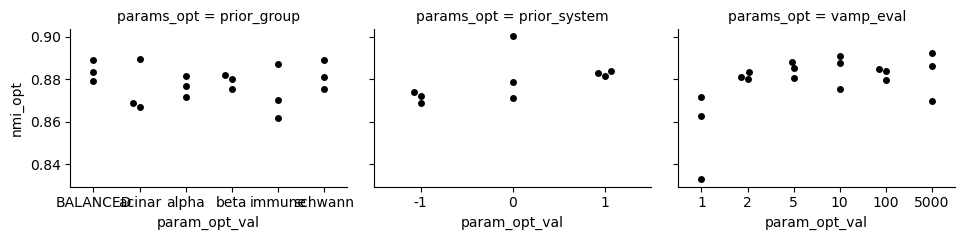

In [48]:
g=sb.catplot( x='param_opt_val', y="nmi_opt",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

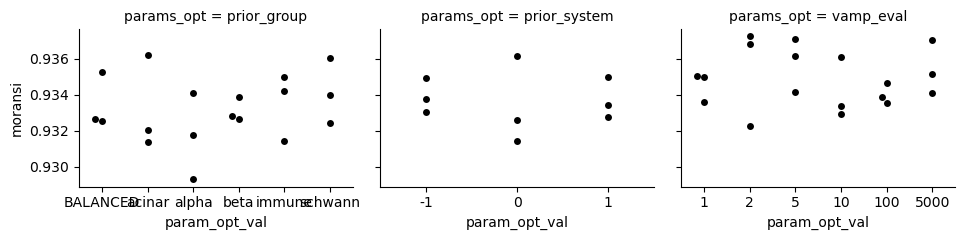

In [49]:
g=sb.catplot( x='param_opt_val', y="moransi",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')

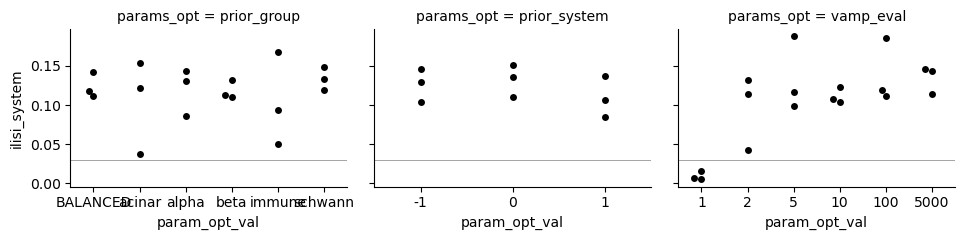

In [50]:
g=sb.catplot( x='param_opt_val', y="ilisi_system",  col='params_opt',
           kind="swarm", data=res,sharex=False,
          height=2.5,aspect=1.3,color='k')
for ax in g.axes.ravel():
    ax.axhline(0.03,lw=0.5,c='gray')